### Transfer from .xml to .json

In [1]:
import xml.etree.ElementTree as ET
import json
import os

def cvat_xml_to_coco_keypoints(xml_path, output_json_path, image_dir):
    # Prasing XML-file
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # Initializing structure of COCO Keypoints
    coco_data = {
        "licenses": [{"name": "", "id": 0, "url": ""}],
        "info": {"contributor": "", "date_created": "", "description": "", "url": "", "version": "", "year": ""},
        "categories": [
            {"id": 1, "name": "wings", "supercategory": "", "keypoints": [], "skeleton": []},
            {"id": 2, "name": "head", "supercategory": "", "keypoints": [], "skeleton": []},
            {"id": 3, "name": "abdomen", "supercategory": "", "keypoints": [], "skeleton": []}
        ],
        "images": [],
        "annotations": []
    }
    
    # Mapping annotations CVAT in ID categories COCO
    label_to_category = {
        "wings": 1,
        "head": 2,
        "abdomen": 3
    }
    
    image_id = 0
    annotation_id = 0
    
    # Processing each image in XML
    for image in root.findall('image'):
        image_id += 1
        image_name = image.get('name')
        width = int(image.get('width'))
        height = int(image.get('height'))
        
        # Adding picture in COCO
        coco_data['images'].append({
            "id": image_id,
            "width": width,
            "height": height,
            "file_name": image_name,
            "license": 0,
            "flickr_url": "",
            "coco_url": "",
            "date_captured": 0
        })
        
        # Processing annotations for current image
        keypoints = []
        for points in image.findall('points'):
            label = points.get('label')
            if label in label_to_category:
                category_id = label_to_category[label]
                point_str = points.get('points')
                if point_str:  
                    # Dividing points by ";"
                    point_pairs = point_str.split(';')
                    for pair in point_pairs:
                        if pair.strip():  
                            x, y = map(float, pair.strip().split(',')) 
                            keypoints.extend([x, y, 1])  
        
        if keypoints:  
            annotation_id += 1
            # Calculating approximate bounding box
            min_x = min([k for i, k in enumerate(keypoints) if i % 3 == 0])
            max_x = max([k for i, k in enumerate(keypoints) if i % 3 == 0])
            min_y = min([k for i, k in enumerate(keypoints) if i % 3 == 1])
            max_y = max([k for i, k in enumerate(keypoints) if i % 3 == 1])
            
            bbox = [min_x, min_y, max_x - min_x, max_y - min_y]
            area = bbox[2] * bbox[3] if bbox[2] > 0 and bbox[3] > 0 else 0
            
            coco_data['annotations'].append({
                "id": annotation_id,
                "image_id": image_id,
                "category_id": category_id,  
                "keypoints": keypoints,
                "num_keypoints": len(keypoints) // 3,
                "bbox": bbox,
                "area": area,
                "iscrowd": 0
            })
    
    # Saving as JSON
    with open(output_json_path, 'w') as f:
        json.dump(coco_data, f, indent=4)
    
    print(f"Processed COCO Keypoints 1.0 file saved as {output_json_path}")

xml_path = r"C:\Users\prol-\Documents\Masters\Thesis\analysis\annotations\annotations.xml"
output_json_path = r"C:\Users\prol-\Documents\Masters\Thesis\analysis\annotations_200_coco_keypoints.json"
image_dir = r"C:\Users\prol-\Documents\Masters\Thesis\analysis\imgs"  
cvat_xml_to_coco_keypoints(xml_path, output_json_path, image_dir)

Processed COCO Keypoints 1.0 file saved as C:\Users\prol-\Documents\Masters\Thesis\analysis\annotations_200_coco_keypoints.json


### Merge .json files

In [2]:
import json
import os

def merge_coco_files(coco_file1, coco_file2, output_file):
    # Reading first COCO file
    with open(coco_file1, 'r') as f:
        coco1 = json.load(f)
    
    # Reading second COCO file
    with open(coco_file2, 'r') as f:
        coco2 = json.load(f)
    
    # Initializing merged COCO file
    merged_coco = {
        "licenses": coco1["licenses"],
        "info": coco1["info"],
        "categories": [],
        "images": [],
        "annotations": []
    }
    
    # Merging categories
    category_name_to_id = {}
    for cat in coco1["categories"]:
        category_name_to_id[cat["name"]] = cat["id"]
        merged_coco["categories"].append(cat)
    
    for cat in coco2["categories"]:
        if cat["name"] not in category_name_to_id:
            new_id = max(category_name_to_id.values(), default=0) + 1
            cat["id"] = new_id
            category_name_to_id[cat["name"]] = new_id
            merged_coco["categories"].append(cat)
        else:
            cat["id"] = category_name_to_id[cat["name"]]
    
    # Merging images
    image_file_to_id = {img["file_name"]: img["id"] for img in coco1["images"]}
    current_image_id = max(image_file_to_id.values(), default=0)
    
    for img in coco1["images"]:
        merged_coco["images"].append(img)
    
    for img in coco2["images"]:
        if img["file_name"] not in image_file_to_id:
            current_image_id += 1
            img["id"] = current_image_id
            image_file_to_id[img["file_name"]] = current_image_id
            merged_coco["images"].append(img)
        else:
            img["id"] = image_file_to_id[img["file_name"]]
    
    # Merging annotations
    annotation_id_map = {ann["id"]: ann for ann in coco1["annotations"]}
    current_annotation_id = max(annotation_id_map.keys(), default=0)
    
    for ann in coco1["annotations"]:
        merged_coco["annotations"].append(ann)
    
    for ann in coco2["annotations"]:
        if ann["id"] not in annotation_id_map:
            current_annotation_id += 1
            ann["id"] = current_annotation_id
            if ann["image_id"] in image_file_to_id:
                ann["image_id"] = image_file_to_id[ann["image_id"]]
            merged_coco["annotations"].append(ann)
        else:
            ann["id"] = annotation_id_map[ann["id"]]
            if ann["image_id"] in image_file_to_id:
                ann["image_id"] = image_file_to_id[ann["image_id"]]
    
    # Saving merged file
    with open(output_file, 'w') as f:
        json.dump(merged_coco, f, indent=4)
    
    print(f"Merged COCO file saved as {output_file}")

coco_file1 = r"C:\Users\prol-\Documents\Masters\Thesis\analysis\annotations\merged.json"
coco_file2 = r"C:\Users\prol-\Documents\Masters\Thesis\analysis\annotations\annotations_200_coco_keypoints.json"
output_file = r"C:\Users\prol-\Documents\Masters\Thesis\analysis\annotations\merged_new.json"

merge_coco_files(coco_file1, coco_file2, output_file)

Merged COCO file saved as C:\Users\prol-\Documents\Masters\Thesis\analysis\annotations\merged_new.json


### Training

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import json
import numpy as np
from PIL import Image
import os

# Loading pretrained model ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(None, None, 3))

# Adding layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
# Changing output layer for 4 points (12 values)
predictions = Dense(4 * 3, activation='linear')(x)  
outputs = Dense(12, activation='sigmoid')(x)  

model = Model(inputs=base_model.input, outputs=outputs)

# Model compilation
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='mse',  # Using mean-squared error for coordinates regression
              metrics=['mae'])

# Loading data from COCO Keypoints JSON
def load_data(coco_file_path, image_dir):
    with open(coco_file_path, 'r') as f:
        coco_data = json.load(f)

    for ann in coco_data['annotations']:
        ann['bbox'][0] /= coco_data['images'][ann['image_id']]['width']
        ann['bbox'][1] /= coco_data['images'][ann['image_id']]['height']
        ann['bbox'][2] /= coco_data['images'][ann['image_id']]['width']
        ann['bbox'][3] /= coco_data['images'][ann['image_id']]['height']

    
    def generator():
        for image_info in coco_data['images']:
            image_id = image_info['id']
            image_path = os.path.join(image_dir, image_info['file_name'])
        
            # Loading image
            if os.path.exists(image_path):
                img = Image.open(image_path).convert('RGB')
                img = img.resize((224, 224))  
                img_array = np.array(img) / 255.0  
                
                annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]
                
                keypoints = []
                if annotations:  
                    for ann in annotations:
    
                        keypoints = [
                            ann['keypoints'][0],  # left_wing_x
                            ann['keypoints'][1],  # left_wing_y
                            ann['keypoints'][2],  # left_wing_vis
                            ann['keypoints'][3],  # right_wing_x
                            ann['keypoints'][4],  # right_wing_y
                            ann['keypoints'][5],  # right_wing_vis
                            ann['keypoints'][6],  # head_x
                            ann['keypoints'][7],  # head_y
                            ann['keypoints'][8],  # head_vis
                            ann['keypoints'][9],  # abdomen_x
                            ann['keypoints'][10],  # abdomen_y
                            ann['keypoints'][11],  # abdomen_vis
                        ]
                else:
                    # If there are no annotations, fill in with zeros
                    keypoints = [0] * 12  
                
                yield img_array, np.array(keypoints)
            else:
                print(f"Image not found: {image_path}")
    
    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),  
            tf.TensorSpec(shape=(12,), dtype=tf.float32)  
        )
    )

coco_file_path = r"C:\Users\prol-\Documents\Masters\Thesis\analysis\annotations\merged_new.json"
image_dir = r'C:\Users\prol-\Documents\Masters\Thesis\analysis\imgs'

# Creating data generators
train_dataset = load_data(coco_file_path, image_dir).batch(32).repeat().prefetch(tf.data.AUTOTUNE)
val_dataset = load_data(coco_file_path, image_dir).batch(32).repeat().prefetch(tf.data.AUTOTUNE)

for img, keypoints in train_dataset.take(1):
    print("Keypoints shape:", keypoints.shape)  
    print("Keypoints:", keypoints)

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=4,  
    validation_steps=4   
)

# saving model
model.save('bee_parts_detection_model_new.keras')

Keypoints shape: (32, 12)
Keypoints: tf.Tensor(
[[25.45 25.69  1.   43.65 81.24  1.   73.1   9.65  1.   59.93 10.61  1.  ]
 [16.59 32.16  1.   33.59 84.59  1.   73.1  21.38  1.   33.59  1.51  1.  ]
 [42.    1.03  1.   81.74 25.21  1.   30.98 81.24  1.   23.8  22.58  1.  ]
 [20.27 21.02  1.   35.9  47.7   1.    6.51 31.44  1.   23.6  72.71  1.  ]
 [ 4.01 33.11  1.   40.9  48.33  1.   19.85 21.44  1.   24.02 73.55  1.  ]
 [21.19 76.93  1.   71.23 29.04  1.   40.82  1.27  1.   19.99 26.17  1.  ]
 [20.48 19.14  1.   17.56 66.46  1.   73.84 23.1   1.   72.8  16.22  1.  ]
 [14.08 72.92  1.   13.45 22.89  1.   71.19 24.14  1.   30.75  1.22  1.  ]
 [74.48 42.95  1.    4.01 48.32  1.   29.69 37.87  1.   33.27 94.9   1.  ]
 [28.94 95.2   1.   70.45 44.14  1.    0.57 49.22  1.   27.15 38.17  1.  ]
 [30.07 27.61  1.   31.03 82.92  1.   76.29 23.06  1.    2.06 26.41  1.  ]
 [ 1.53 38.86  1.   81.03 34.79  1.   38.89 30.72  1.   42.48 83.88  1.  ]
 [42.45 81.48  1.   66.88 18.75  1.   26.65 16.59  1

### Prediction

In [5]:
import xml.etree.ElementTree as ET
import os

def merge_xml_files(xml_paths, output_path):
    """
   Combines several CVAT XML files into one with unique annotation IDs
    Args:
        xml_paths (list): List of paths to XML files to combine
        output_path (str): The path to save the merged file.
    Returns:
        str: The path to the merged file
    """
    # Checking for files
    for path in xml_paths:
        if not os.path.exists(path):
            raise FileNotFoundError(f"XML file not found: {path}")

    try:
        # Creating a basic structure from the first file
        base_tree = ET.parse(xml_paths[0])
        base_root = base_tree.getroot()
        
        # Deleting all images from the base file
        for image in base_root.findall('image'):
            base_root.remove(image)
        
        # Counter for unique IDs
        annotation_id = 1
        image_id = 1
        
        # Collecting and combining data
        for xml_path in xml_paths:
            tree = ET.parse(xml_path)
            root = tree.getroot()
            
            for image in root.findall('image'):
                image.set('id', str(image_id))
                image_id += 1
                
                for ann in image.findall('*'):
                    if 'id' in ann.attrib:
                        ann.set('id', str(annotation_id))
                        annotation_id += 1
                
                base_root.append(image)
        
        # Updating meta information
        meta = base_root.find('meta')
        if meta is not None:
            job = meta.find('job')
            if job is not None:
                # Updating the number of images
                size_elem = job.find('size')
                if size_elem is not None:
                    size_elem.text = str(image_id - 1)
                
                # Updating frame range
                start_frame = job.find('start_frame')
                if start_frame is not None:
                    start_frame.text = '0'
                stop_frame = job.find('stop_frame')
                if stop_frame is not None:
                    stop_frame.text = str(image_id - 2)
        
        # Saving merged file
        base_tree.write(output_path, encoding='utf-8', xml_declaration=True)
        print(f"Successfully merged {len(xml_paths)} files in {output_path}")
        print(f"Total images: {image_id-1}, annotations: {annotation_id-1}")
        return output_path

    except ET.ParseError as e:
        raise ValueError(f"Parsing error XML: {str(e)}")
    except Exception as e:
        raise RuntimeError(f"Error while merging files: {str(e)}")

if __name__ == "__main__":
    xml_files = [
        r"C:\Users\prol-\Documents\Masters\Thesis\analysis\annotations\annotations_101.xml",
        r"C:\Users\prol-\Documents\Masters\Thesis\analysis\annotations\annotations_24.xml",
        r"C:\Users\prol-\Documents\Masters\Thesis\analysis\annotations\annotations.xml"
    ]
    
    try:
        merged_file = merge_xml_files(xml_files, "merged_annotations.xml")
        print(f"The result saved in: {merged_file}")
    except Exception as e:
        print(f"Error: {str(e)}")

Successfully merged 3 files in merged_annotations.xml
Total images: 326, annotations: 0
The result saved in: merged_annotations.xml


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import xml.etree.ElementTree as ET
import numpy as np
from PIL import Image, ImageOps
import os
import matplotlib.pyplot as plt

def parse_cvat_xml(xml_path):
    """CVAT XML parsing with point processing"""
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    annotations = []
    for image in root.findall('image'):
        img_data = {
            'name': image.get('name'),
            'width': float(image.get('width')),
            'height': float(image.get('height')),
            'points': {'head': None, 'abdomen': None, 'wing_1': None, 'wing_2': None}
        }
        
        wing_count = 0
        for points in image.findall('points'):
            label = points.get('label')
            points_str = points.get('points').split(';')
            occluded = points.get('occluded', '0') == '1'
            
            for point_str in points_str[:2]:  
                x, y = map(float, point_str.split(','))
                
                if label == 'wings':
                    wing_count += 1
                    if wing_count > 2:
                        continue
                    point_name = f'wing_{wing_count}'
                elif label in ['head', 'abdomen']:
                    point_name = label
                else:
                    continue
                
                img_data['points'][point_name] = {
                    'x': x, 'y': y, 'v': 0 if occluded else 1
                }
        
        annotations.append(img_data)
    return annotations

def create_dataset(xml_path, image_dir, batch_size=32):
    """Creates a tf.data.Dataset with infinite repetition"""
    annotations = parse_cvat_xml(xml_path)
    
    def generator():
        while True:  
            for ann in annotations:
                image_path = os.path.join(image_dir, ann['name'])
                if not os.path.exists(image_path):
                    continue
                
                img = Image.open(image_path).convert('RGB')
                img = ImageOps.pad(img, (224, 224), method=Image.Resampling.BILINEAR)
                img_array = np.array(img) / 255.0
                
                keypoints = []
                for point_name in ['head', 'abdomen', 'wing_1', 'wing_2']:
                    point = ann['points'][point_name]
                    keypoints.extend([
                        point['x']/ann['width'] if point else 0,
                        point['y']/ann['height'] if point else 0,
                        point['v'] if point else 0
                    ])
                
                yield img_array, np.array(keypoints, dtype=np.float32)
    
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(12,), dtype=np.float32)
        )
    )
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

def create_model():
    """Creates a model based on ResNet50 with proper layer freezing"""
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    outputs = Dense(12, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    
    return model



def visualize_errors(image_path, model, xml_path):
    """Visualization of predictions and true points"""
    annotations = parse_cvat_xml(xml_path)
    image_name = os.path.basename(image_path)
    ann = next((a for a in annotations if a['name'] == image_name), None)
    
    if not ann:
        print(f"Annotations for {image_name} not found")
        return

    img = Image.open(image_path).convert('RGB')
    original_size = img.size
    img_array = np.array(ImageOps.pad(img, (224, 224))) / 255.0
    pred = model.predict(np.expand_dims(img_array, axis=0), verbose=0)[0]
    
    predicted_points = {}
    point_names = ['head', 'abdomen', 'wing_1', 'wing_2']
    for i, name in enumerate(point_names):
        idx = i * 3
        predicted_points[name] = [
            int(pred[idx] * original_size[0]),
            int(pred[idx+1] * original_size[1]),
            pred[idx+2]
        ]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    
    colors = {'head': 'green', 'abdomen': 'blue', 'wing_1': 'red', 'wing_2': 'orange'}
    
    for name in point_names:
        if predicted_points[name][2] > 0.5:
            plt.plot(predicted_points[name][0], predicted_points[name][1], 
                    'o', color=colors[name], label=f'{name} (pred)')
        
        point = ann['points'][name]
        if point and point['v']:
            plt.plot(point['x'], point['y'], 'x', 
                    color=colors[name], markersize=10, label=f'{name} (true)')
    
    plt.legend()
    plt.axis('off')
    plt.show()

def main():
    xml_path = "merged_annotations.xml"
    image_dir = r"C:\Users\prol-\Documents\Masters\Thesis\analysis\imgs"
    model_path = "bee_model.keras"
    
    # Creating model
    model = create_model()
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='mse',
        metrics=['mae']
    )
    
    # Creating dataset
    train_dataset = create_dataset(xml_path, image_dir, batch_size=32)
    num_images = len(parse_cvat_xml(xml_path))
    steps_per_epoch = max(1, num_images // 32)
    
    print(f"Start of training on {num_images} images")
    print(f"Steps per epoch: {steps_per_epoch}")
    
    # Training
    history = model.fit(
        train_dataset,
        epochs=20,
        steps_per_epoch=steps_per_epoch,
        verbose=1
    )
    
    # Fine-tuning (defrost all layers)
    model.layers[1].trainable = True  
    
    # Recompiling after changing trainable
    model.compile(
        optimizer=Adam(learning_rate=0.00001),
        loss='mse',
        metrics=['mae']
    )
    
    model.fit(
        train_dataset,
        epochs=10,
        steps_per_epoch=steps_per_epoch,
        verbose=1
    )
    
    # Saving model
    model.save(model_path)
    print(f"Модель сохранена в {model_path}")
    
    # Testing
    test_image = r"C:\Users\prol-\Documents\Masters\Thesis\dataset\bee_00856.jpg"
    if os.path.exists(test_image):
        visualize_errors(test_image, model, xml_path)
    else:
        print(f"The test image was not found: {test_image}")

if __name__ == "__main__":
    main()

Start of training on 326 images
Steps per epoch: 10
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - loss: 0.1320 - mae: 0.3127
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - loss: 0.0463 - mae: 0.1530
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 0.0420 - mae: 0.1255
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 0.0403 - mae: 0.1214
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 0.0384 - mae: 0.1180
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 0.0378 - mae: 0.1145
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - loss: 0.0370 - mae: 0.1124
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 0.0350 - mae: 0.1101
Epoch 9/20
 4/10 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - loss: 0.0346 - mae: 0.1102


Dataset sizes - Train: 140, Val: 20, Test: 41
Steps per epoch: 4, Validation steps: 1

Initial training with frozen layers...
Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 54s 7s/step - loss: 0.0935 - mae: 0.2534 - val_loss: 0.0711 - val_mae: 0.2205 - learning_rate: 1.0000e-04
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step - loss: 0.0251 - mae: 0.1041 - val_loss: 0.0411 - val_mae: 0.1654 - learning_rate: 1.0000e-04
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - loss: 0.0249 - mae: 0.0916 - val_loss: 0.0326 - val_mae: 0.1428 - learning_rate: 1.0000e-04
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step - loss: 0.0235 - mae: 0.0922 - val_loss: 0.0287 - val_mae: 0.1283 - learning_rate: 1.0000e-04
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - loss: 0.0218 - mae: 0.0858 - val_loss: 0.0275 - val_mae: 0.1225 - learning_rate: 1.0000e-04
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step - loss: 0.0185 - mae: 0.0793 - val_loss: 0.0273 - val_mae: 0.1209 - learning_rate: 1.0000e-04
Epoch 7/30
4/4 ━━━━━━

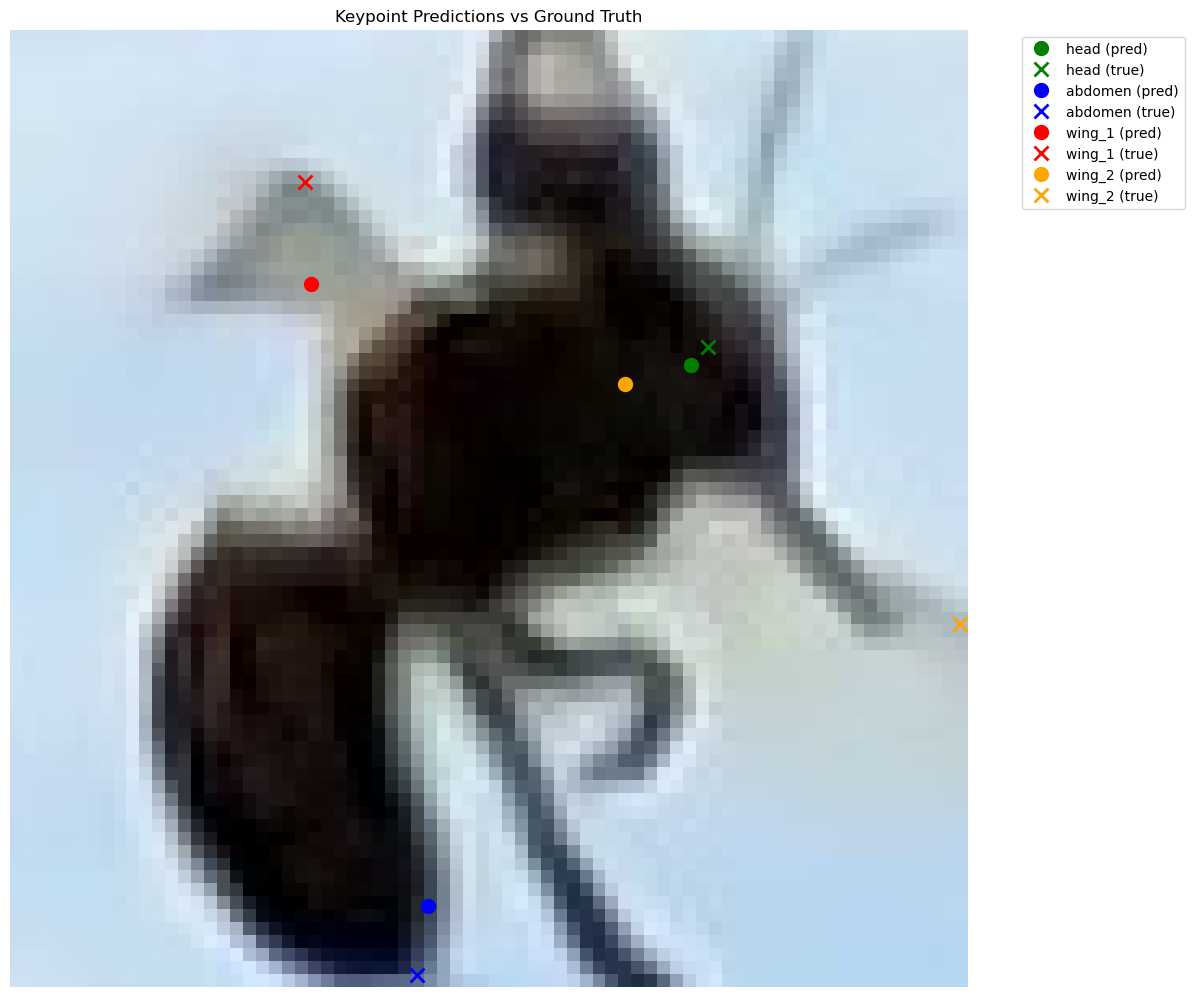

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import xml.etree.ElementTree as ET
import numpy as np
from PIL import Image, ImageOps
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def parse_cvat_xml(xml_path):
    """Parse CVAT XML annotations with keypoint handling"""
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        annotations = []
        for image in root.findall('image'):
            img_data = {
                'name': image.get('name'),
                'width': float(image.get('width')),
                'height': float(image.get('height')),
                'points': {'head': None, 'abdomen': None, 'wing_1': None, 'wing_2': None}
            }
            
            wing_count = 0
            for points in image.findall('points'):
                label = points.get('label')
                points_str = points.get('points').split(';')
                occluded = points.get('occluded', '0') == '1'
                
                for point_str in points_str[:2]:  # Only first 2 points for wings
                    x, y = map(float, point_str.split(','))
                    
                    if label == 'wings':
                        wing_count += 1
                        if wing_count > 2:
                            continue
                        point_name = f'wing_{wing_count}'
                    elif label in ['head', 'abdomen']:
                        point_name = label
                    else:
                        continue
                    
                    img_data['points'][point_name] = {
                        'x': x, 'y': y, 'v': 0 if occluded else 1
                    }
            
            annotations.append(img_data)
        return annotations
    except Exception as e:
        print(f"Error parsing XML: {e}")
        return []

def create_datasets(xml_path, image_dir, test_size=0.2, val_size=0.1, batch_size=32):
    """Create train, validation, and test datasets with proper splitting"""
    annotations = parse_cvat_xml(xml_path)
    if not annotations:
        raise ValueError("No annotations found or error parsing XML")
    
    # Filter out images that don't exist
    valid_annotations = []
    for ann in annotations:
        image_path = os.path.join(image_dir, ann['name'])
        if os.path.exists(image_path):
            valid_annotations.append(ann)
    
    if not valid_annotations:
        raise ValueError("No valid images found in the specified directory")
    
    # Split data into train, validation, and test sets
    train_val, test = train_test_split(valid_annotations, test_size=test_size, random_state=42)
    train, val = train_test_split(train_val, test_size=val_size/(1-test_size), random_state=42)
    
    def dataset_generator(data_split):
        for ann in data_split:
            try:
                image_path = os.path.join(image_dir, ann['name'])
                img = Image.open(image_path).convert('RGB')
                img = ImageOps.pad(img, (224, 224), method=Image.Resampling.BILINEAR)
                img_array = np.array(img) / 255.0
                
                keypoints = []
                for point_name in ['head', 'abdomen', 'wing_1', 'wing_2']:
                    point = ann['points'][point_name]
                    keypoints.extend([
                        point['x']/ann['width'] if point else 0,
                        point['y']/ann['height'] if point else 0,
                        point['v'] if point else 0
                    ])
                
                yield img_array, np.array(keypoints, dtype=np.float32)
            except Exception as e:
                print(f"Skipping image {ann['name']} due to error: {e}")
                continue
    
    # Create datasets for each split
    output_signature = (
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(12,), dtype=np.float32)
    )
    
    # Use repeat() to avoid running out of data
    train_ds = tf.data.Dataset.from_generator(
        lambda: dataset_generator(train),
        output_signature=output_signature
    ).repeat().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    val_ds = tf.data.Dataset.from_generator(
        lambda: dataset_generator(val),
        output_signature=output_signature
    ).repeat().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    test_ds = tf.data.Dataset.from_generator(
        lambda: dataset_generator(test),
        output_signature=output_signature
    ).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return train_ds, val_ds, test_ds, len(train), len(val), len(test)

def create_enhanced_model():
    """Create improved model with better architecture"""
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze initial layers
    for layer in base_model.layers[:100]:
        layer.trainable = False
    
    # Create new model
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(12, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    return model

def train_model(model, train_ds, val_ds, steps_per_epoch, validation_steps, epochs=30):
    """Train model with callbacks and learning rate scheduling"""
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    ]
    
    # Initial training with frozen layers
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='mse',
        metrics=['mae']
    )
    
    print("\nInitial training with frozen layers...")
    history = model.fit(
        train_ds,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=1
    )
    
    # Fine-tuning with unfrozen layers
    for layer in model.layers[1].layers[-20:]:  # Unfreeze last 20 layers of ResNet
        layer.trainable = True
    
    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss='mse',
        metrics=['mae']
    )
    
    print("\nFine-tuning with unfrozen layers...")
    model.fit(
        train_ds,
        epochs=epochs//2,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=1
    )
    
    return model

def evaluate_model(model, test_ds):
    """Evaluate model on test set"""
    print("\nEvaluating on test set...")
    try:
        # Evaluate on all test data (don't specify steps)
        results = model.evaluate(test_ds, verbose=1)
        if isinstance(results, list) and len(results) >= 2:
            print(f"Test Loss: {results[0]:.4f}, Test MAE: {results[1]:.4f}")
        else:
            print("Unexpected evaluation results format:", results)
    except Exception as e:
        print(f"Error during evaluation: {e}")

def visualize_predictions(image_path, model, xml_path):
    """Visualize predictions vs ground truth"""
    annotations = parse_cvat_xml(xml_path)
    if not annotations:
        print("No annotations found")
        return
        
    image_name = os.path.basename(image_path)
    ann = next((a for a in annotations if a['name'] == image_name), None)
    
    if not ann:
        print(f"Annotations for {image_name} not found")
        return

    try:
        # Load and predict
        img = Image.open(image_path).convert('RGB')
        original_size = img.size
        img_array = np.array(ImageOps.pad(img, (224, 224))) / 255.0
        pred = model.predict(np.expand_dims(img_array, axis=0), verbose=0)[0]
        
        # Process predictions
        predicted_points = {}
        point_names = ['head', 'abdomen', 'wing_1', 'wing_2']
        for i, name in enumerate(point_names):
            idx = i * 3
            predicted_points[name] = {
                'x': pred[idx] * original_size[0],
                'y': pred[idx+1] * original_size[1],
                'v': pred[idx+2] > 0.5  # Visibility threshold
            }
        
        # Visualization
        plt.figure(figsize=(12, 12))
        plt.imshow(img)
        
        colors = {'head': 'green', 'abdomen': 'blue', 'wing_1': 'red', 'wing_2': 'orange'}
        markers = {'pred': 'o', 'true': 'x'}
        
        # Plot points
        for name in point_names:
            # Predicted points
            if predicted_points[name]['v']:
                plt.plot(predicted_points[name]['x'], predicted_points[name]['y'], 
                        markers['pred'], color=colors[name], 
                        markersize=10, label=f'{name} (pred)')
            
            # True points
            point = ann['points'][name]
            if point and point['v']:
                plt.plot(point['x'], point['y'], markers['true'], 
                        color=colors[name], markersize=10, 
                        markeredgewidth=2, label=f'{name} (true)')
        
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title('Keypoint Predictions vs Ground Truth')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error visualizing predictions: {e}")

def main():
    try:
        # Path configuration
        xml_path = r"C:\Users\prol-\Documents\Masters\Thesis\analysis\annotations\annotations.xml"
        image_dir = r"C:\Users\prol-\Documents\Masters\Thesis\analysis\imgs"
        model_path = "bee_model.keras"
        
        # Create datasets
        train_ds, val_ds, test_ds, train_size, val_size, test_size = create_datasets(xml_path, image_dir)
        
        # Calculate steps
        batch_size = 32
        steps_per_epoch = max(1, train_size // batch_size)
        val_steps = max(1, val_size // batch_size)
        
        print(f"\nDataset sizes - Train: {train_size}, Val: {val_size}, Test: {test_size}")
        print(f"Steps per epoch: {steps_per_epoch}, Validation steps: {val_steps}")
        
        # Create and train model
        model = create_enhanced_model()
        model = train_model(model, train_ds, val_ds, steps_per_epoch, val_steps)
        
        # Evaluate and save
        evaluate_model(model, test_ds)
        model.save(model_path)
        print(f"Model saved to {model_path}")
        
        # Visualization example
        test_image = os.path.join(image_dir, "bee_00856.jpg")
        if os.path.exists(test_image):
            visualize_predictions(test_image, model, xml_path)
        else:
            print("\nTest image not found, using first available test image")
            for test_batch in test_ds.take(1):
                test_image_array = test_batch[0][0].numpy()
                plt.figure(figsize=(8, 8))
                plt.imshow(test_image_array)
                plt.title("Sample Test Image")
                plt.axis('off')
                plt.show()
                
    except Exception as e:
        print(f"\nError in main execution: {e}")

if __name__ == "__main__":
    main()